In [1]:
from TopoAnalysis import dem as d
import pandas as pd
import seaborn
import matplotlib.pylab as plt

In [2]:
prefix = 'conc_05_Rf05percent_1.0'
directory = 'path/to/folder/' + 'Landscape_evolution_models/'
filled = d.FilledElevation.load(directory + prefix + '_filled')
fd = d.FlowDirectionD8.load(directory + prefix + '_flow_direction')
area = d.Area.load(directory + prefix + '_area')
logarea = d.LogArea(area=area)
hs = d.Hillshade.load(directory + prefix + '_hillshade')

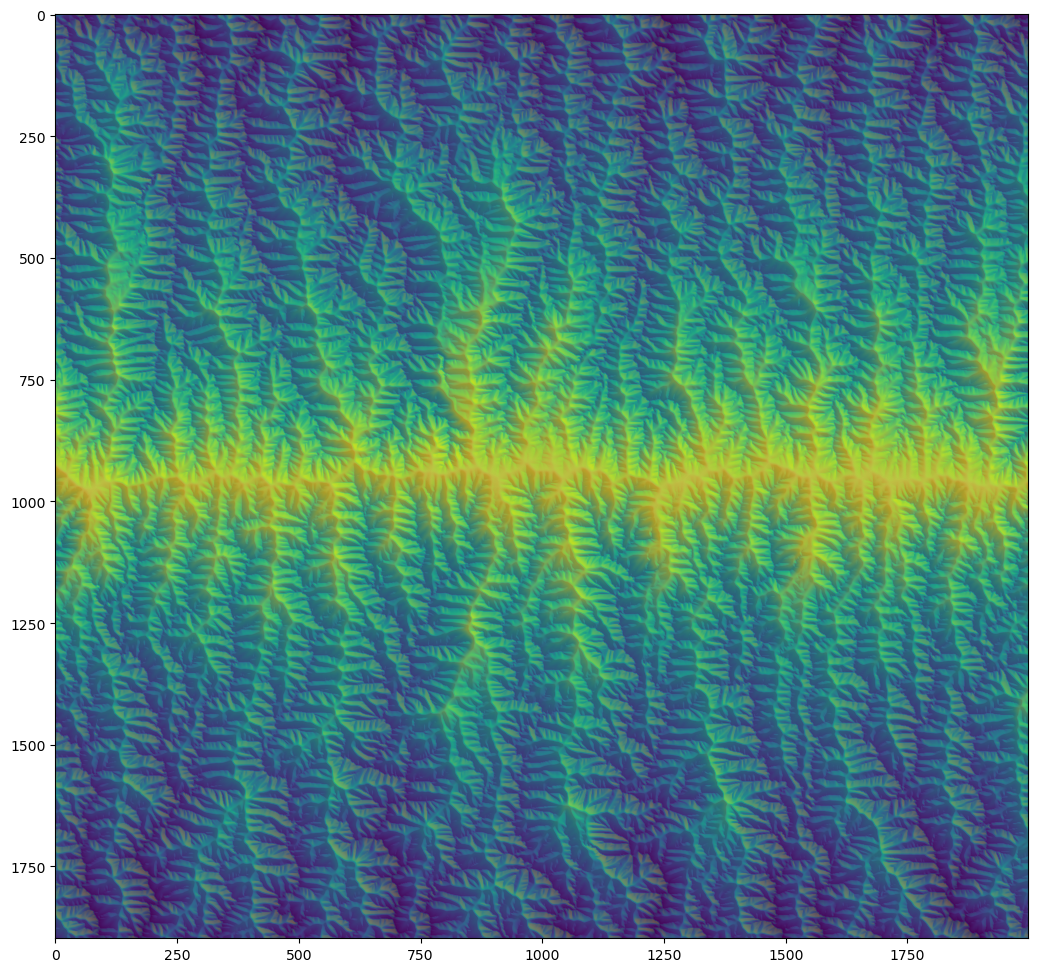

In [3]:
plt.figure(figsize=(24, 12))
plt.imshow(hs._griddata, alpha = 1)
plt.imshow(filled._griddata, alpha = 0.7)

In [14]:
channel_slope = d.ChannelSlopeWithSmoothing(elevation = filled, area = area, flow_direction = fd, 
                                            vertical_interval = 10, min_area = 1E5)


completed flow graph in: 15.94019603729248 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

In [15]:
from pylem.pyas import area_dinf as area_calc
a, s = area_calc(filled._griddata, dx=10)

/var/folders/dc/8z7j2w813y3_j_t1330nl9m40000gq/T/ipykernel_3165/1602003930.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


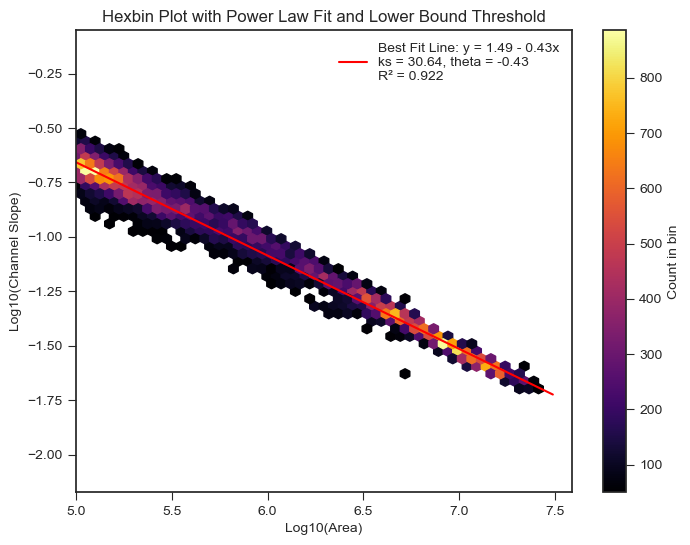

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Set theme for the plot
plt.style.use('seaborn-ticks')

# Your data
i = np.where(~np.isnan(channel_slope._griddata))
x = np.log10(area._griddata[i])  # Log transformation
y = np.log10(channel_slope._griddata[i])  # Log transformation

# Define the linear form of the log-transformed power law equation
def linear_slope_area(log_area, log_ks, theta):
    return log_ks - theta * log_area

# Perform curve fitting
popt, pcov = curve_fit(linear_slope_area, x, y)

# Extract ks and theta values
theta = -popt[1]
ks = 10**popt[0]

# Calculate R-squared
residuals = y - linear_slope_area(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)

# Create hexbin plot with 'inferno' colormap and a lower bounds threshold
plt.figure(figsize=(8, 6))
plt.hexbin(x, y, gridsize=50, cmap="inferno", mincnt=50)  # Set mincnt as desired
plt.colorbar(label='Count in bin')

# Plot regression line
areas_sorted = np.sort(x)
plt.plot(areas_sorted, linear_slope_area(areas_sorted, *popt), 'r-', 
         label=f'Best Fit Line: y = {popt[0]:.2f} - {abs(popt[1]):.2f}x\nks = {ks:.2f}, theta = {theta:.2f}\nRÂ² = {r_squared:.3f}')

# Improve aesthetics
plt.xlabel('Log10(Area)')
plt.ylabel('Log10(Channel Slope)')
plt.title('Hexbin Plot with Power Law Fit and Lower Bound Threshold')
plt.legend()
plt.xlim(np.log10(1E5), max(x + .1))


plt.show()
